In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

## Test start >>>

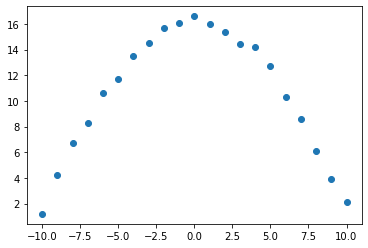

In [3]:
xdata = [ -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
ydata = [1.2, 4.2, 6.7, 8.3, 10.6, 11.7, 13.5, 14.5, 15.7, 16.1, 16.6, 16.0, 15.4, 14.4, 14.2, 12.7, 10.3, 8.6, 6.1, 3.9, 2.1]

#Recast xdata and ydata into numpy arrays so we can use their handy features
xdata = np.asarray(xdata)
ydata = np.asarray(ydata)
plt.plot(xdata, ydata, 'o')

In [4]:
# Define the Gaussian function
def Gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y

In [5]:
parameters, covariance = curve_fit(Gauss, xdata, ydata)

/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_82763/4020519507.py:3: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*x**2)


In [6]:
fit_A = parameters[0]
fit_B = parameters[1]
print(fit_A)
print(fit_B)

16.934286340519687
0.015739600927241554


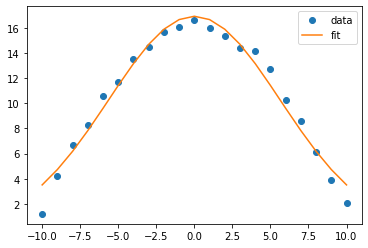

In [7]:
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

## Test finished <<<

# FACE ORNL Sweetgum

Height data: https://data.ess-dive.lbl.gov/view/doi:10.15485/1798175#ess-dive-8d90274b273a0b3-20210420T011652099 <br>
Basal Area: https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1463816#ess-dive-60f6d2e30a26980-20180716T151742599166 <br>

Using ambient data for calculating the allometries.

## Height Allometry
### Paths

In [35]:

paths = {}
paths ['height'] = f'/Users/ud4/repos/GitHub/FATESFACE/FACE_data/H2D/Height/'
#https://data.ess-dive.lbl.gov/view/doi:10.15485/1798175#ess-dive-8d90274b273a0b3-20210420T011652099

# BA: Basal Area
paths ['BA'] = f'/Users/ud4/repos/GitHub/FATESFACE/FACE_data/H2D/BasalArea/data/'
# https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1463816#ess-dive-60f6d2e30a26980-20180716T151742599166


In [269]:
pwd

'/Users/ud4/repos/GitHub/FATESFACE/Jupyter_Notebooks'

### Read Heights data

In [13]:


# Read the CSV file from the path into a DataFrame
df_heights = pd.read_csv(paths ['height']+ 'Height.csv')

# Display the DataFrame
print(df_heights)

      Plot  TreeID  Year Height (m)
0        1      14  1997       12.1
1        1      15  1997       13.4
2        1      16  1997       12.1
3        1      17  1997       12.0
4        1      18  1997       11.9
...    ...     ...   ...        ...
1620     5      89  2009       10.5
1621     5      90  2009       18.0
1622     5      91  2009       18.3
1623     5      92  2009       14.5
1624     5      93  2009       19.6

[1625 rows x 4 columns]


| Plot ID | Experiment |
|:--------------:|:-------:|
| 1 | Elevated |
| 2 | Elevated |
| 3 | Ambient |
| 4 | Control |
| 5 | Control |

Let's find allometry for Plot id 3

In [16]:
df_heights_plot3 = df_heights[df_heights['Plot'] == 3]
df_heights_plot3

,Plot,TreeID,Year,Height (m)
50,3,16,1997,12.1
51,3,17,1997,12.1
52,3,18,1997,12.7
53,3,19,1997,12.6
54,3,20,1997,13.1
...,...,...,...,...
1570,3,65,2009,19.1
1571,3,67,2009,21.4
1572,3,82,2009,21.6
1573,3,83,2009,16.0


In [27]:
# Convert 'Height (m)' column to float, handling exceptions by converting to NaN
df_heights_plot3['Height (m)'] = pd.to_numeric(df_heights_plot3['Height (m)'], errors='coerce')

/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_82763/4150526309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heights_plot3['Height (m)'] = pd.to_numeric(df_heights_plot3['Height (m)'], errors='coerce')


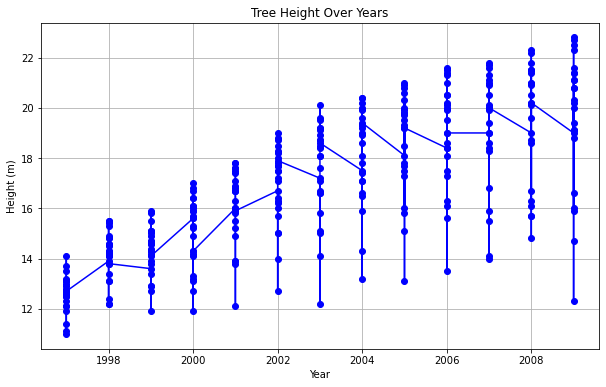

In [34]:
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named 'df'
# If not, replace 'df' with the actual DataFrame name

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_heights_plot3['Year'], df_heights_plot3['Height (m)'], marker='o', linestyle='-', color='b')
plt.title('Tree Height Over Years')
plt.xlabel('Year')
plt.ylabel('Height (m)')
plt.grid(True)
plt.show()


In [29]:
# Group by 'Year' and calculate the average height for each year
average_height_per_year = df_heights_plot3.groupby('Year')['Height (m)'].mean().reset_index()

# Display the result
print(average_height_per_year)


    Year  Height (m)
0   1997   12.588000
1   1998   14.120000
2   1999   14.296000
3   2000   15.068000
4   2001   16.072000
5   2002   16.956000
6   2003   17.548000
7   2004   18.154167
8   2005   18.620833
9   2006   18.970833
10  2007   19.120833
11  2008   19.470833
12  2009   19.579167


### Read Basal Areas

In [93]:
df_BA = {}

year_in = 1997

# Read the .dat file from the path into a DataFrame
file_path = paths ['BA']+ f'ba{year_in}.dat'
# Read the .dat file into a DataFrame
df_BA[year_in] = pd.read_table(file_path, skiprows=7, delim_whitespace=True)

# Select the 2: cols and calculate the average
average_ba = df_BA[year_in].iloc[:, 2:].mean(axis=1)
# Drop the all the cols used for averaging
df_BA[year_in] = df_BA[year_in].iloc[:, :2]
# use average in dataframe
df_BA[year_in]['AverageBA'] = round(average_ba,2)
#Renaming cols
df_BA[year_in]= df_BA[year_in].rename(columns={'RING':'Plot','TREE':'TreeID'})
df_BA[year_in]['Year'] = year_in

#df_BA[year_in]

In [94]:
for year_in in range(1997, 2008):
    # Read the .dat file from the path into a DataFrame
    file_path = paths ['BA']+ f'ba{year_in}.dat'
    # Read the .dat file into a DataFrame
    df_BA[year_in] = pd.read_table(file_path, skiprows=7, delim_whitespace=True)

    # Select the 2: cols and calculate the average
    average_ba = df_BA[year_in].iloc[:, 2:].mean(axis=1)
    # Drop the all the cols used for averaging
    df_BA[year_in] = df_BA[year_in].iloc[:, :2]
    df_BA[year_in]['Year'] = year_in
    # use average in dataframe
    df_BA[year_in]['AverageBA cm2'] = round(average_ba,2)
    #Renaming cols
    df_BA[year_in]= df_BA[year_in].rename(columns={'RING':'Plot','TREE':'TreeID'})


In [99]:
# Initialize an empty DataFrame to store the result
df_ba_all = pd.DataFrame()

# Loop through the list of DataFrames and concatenate them
for k in df_BA.keys():
    df_ba_all = pd.concat([df_ba_all, df_BA[k]], ignore_index=True)

In [100]:
df_ba_plot3 = df_ba_all[df_ba_all['Plot'] == 3]

In [101]:
df_ba_plot3

,Plot,TreeID,Year,AverageBA cm2
170,3,2,1997,136.86
171,3,3,1997,131.14
172,3,4,1997,122.14
173,3,5,1997,95.00
174,3,6,1997,94.29
...,...,...,...,...
4687,3,93,2007,127.00
4688,3,94,2007,88.00
4689,3,95,2007,135.71
4690,3,96,2007,237.00


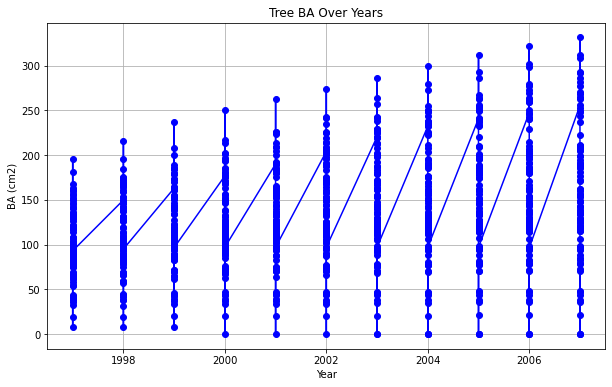

In [120]:
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named 'df'
# If not, replace 'df' with the actual DataFrame name

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_ba_plot3['Year'], df_ba_plot3['AverageBA cm2'], marker='o', linestyle='-', color='b')
plt.title('Tree BA Over Years')
plt.xlabel('Year')
plt.ylabel('BA (cm2)')
plt.grid(True)
plt.show()


In [107]:
df_heights_plot3

,Plot,TreeID,Year,Height (m)
50,3,16,1997,12.1
51,3,17,1997,12.1
52,3,18,1997,12.7
53,3,19,1997,12.6
54,3,20,1997,13.1
...,...,...,...,...
1570,3,65,2009,19.1
1571,3,67,2009,21.4
1572,3,82,2009,21.6
1573,3,83,2009,16.0


In [108]:
# Merge Height and BA

# Merge DataFrames based on the 'ID' column
merged_df = pd.merge(df_ba_plot3, df_heights_plot3, on=['Plot', 'TreeID','Year'], how='inner')

In [109]:
merged_df

,Plot,TreeID,Year,AverageBA cm2,Height (m)
0,3,16,1997,120.71,12.1
1,3,17,1997,103.00,12.1
2,3,18,1997,163.43,12.7
3,3,19,1997,130.14,12.6
4,3,20,1997,154.86,13.1
...,...,...,...,...,...
270,3,65,2007,148.14,18.3
271,3,67,2007,190.43,20.5
272,3,82,2007,282.29,21.1
273,3,83,2007,79.00,16.8


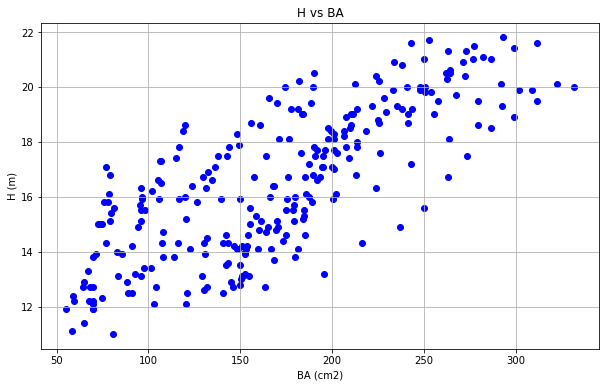

In [123]:
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named 'df'
# If not, replace 'df' with the actual DataFrame name

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['AverageBA cm2'], merged_df['Height (m)'], marker='o', linestyle='-', color='b')
plt.title('H vs BA')
plt.xlabel('BA (cm2)')
plt.ylabel('H (m)')
plt.grid(True)
plt.show()


In [116]:
# Group by 'Year' and calculate the average height for each year
average_BA_H_per_year = merged_df.groupby('Year')[['AverageBA cm2','Height (m)']].mean().reset_index()

# Display the result
print(average_BA_H_per_year)

    Year  AverageBA cm2  Height (m)
0   1997       122.7764   12.588000
1   1998       133.2204   14.120000
2   1999       143.5560   14.296000
3   2000       151.9288   15.068000
4   2001       161.4124   16.072000
5   2002       170.3120   16.956000
6   2003       180.3364   17.548000
7   2004       184.9804   18.154167
8   2005       192.0460   18.620833
9   2006       198.0124   18.970833
10  2007       204.0624   19.120833


In [213]:
import math

def area_to_diameter(area):
    diameter = math.sqrt((4 * area) / math.pi)
    return diameter

# Apply the function to the 'CircleArea' column
average_BA_H_per_year['AverageD (cm)'] = average_BA_H_per_year['AverageBA cm2'].apply(area_to_diameter)
merged_df['AverageD (cm)'] = merged_df['AverageBA cm2'].apply(area_to_diameter)

In [214]:
average_BA_H_per_year

,Year,AverageBA cm2,Height (m),AverageD (cm)
0,1997,122.7764,12.588000,12.502950
1,1998,133.2204,14.120000,13.023881
2,1999,143.5560,14.296000,13.519659
3,2000,151.9288,15.068000,13.908334
4,2001,161.4124,16.072000,14.335852
5,2002,170.3120,16.956000,14.725759
6,2003,180.3364,17.548000,15.152935
7,2004,184.9804,18.154167,15.346803
8,2005,192.0460,18.620833,15.637153
9,2006,198.0124,18.970833,15.878199


## Diameter to height allometries

### 1. Martinez Cano
h = (p1 * d**(p2))/(p3+d**(p2))

<br>
where, <br>
h in m <br>
d in cm <br>



In [215]:
# Define the Martinez Cano function
def MartinezCano(d, p1, p2, p3):
    """
    https://bg.copernicus.org/articles/16/847/2019/
    """
    h = (p1 * d**(p2))/(p3+d**(p2))
    return h

In [238]:
def MartinezCano(d, p1, p2, p3, dbh_maxh=80):
    dbh_maxh = 80
    h = (p1 * d**p2) / (p3 + d**p2)
    return h


In [247]:
test_x = [10,15,20,25,30]
p1 = 58
p2 = .73
p3 = 21.8
test_y = [MartinezCano(d, p1, p2, p3) for d in test_x ]
print(test_y)

parameters, covariance = curve_fit(MartinezCano, test_x, test_y)
print (parameters)

p1 = parameters[0]
p2 = parameters[1]
p3 = parameters[2]

[11.463923326582265, 14.430283404440585, 16.82428323677534, 18.834186432792954, 20.56472939584703]
[58.    0.73 21.8   1.  ]


/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


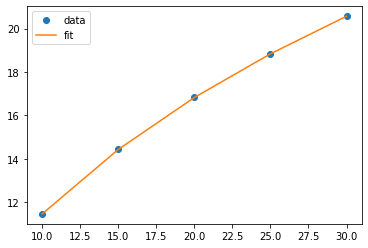

In [248]:
fit_y = MartinezCano(test_x, p1, p2, p3)
plt.plot(test_x, test_y, 'o', label='data')
plt.plot(test_x, fit_y, '-', label='fit')
plt.legend()

In [249]:
# Using all the data for plot 3
merged_df

,Plot,TreeID,Year,AverageBA cm2,Height (m),AverageD (cm)
0,3,16,1997,120.71,12.1,12.397288
1,3,17,1997,103.00,12.1,11.451798
2,3,18,1997,163.43,12.7,14.425170
3,3,19,1997,130.14,12.6,12.872428
4,3,20,1997,154.86,13.1,14.041862
...,...,...,...,...,...,...
270,3,65,2007,148.14,18.3,13.733816
271,3,67,2007,190.43,20.5,15.571224
272,3,82,2007,282.29,21.1,18.958449
273,3,83,2007,79.00,16.8,10.029253


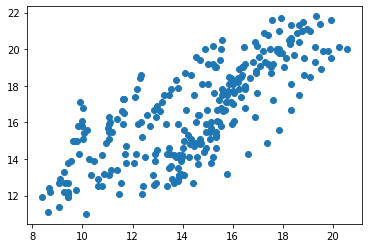

In [250]:

xdata = merged_df['AverageD (cm)']
ydata = merged_df['Height (m)']

plt.scatter(xdata,ydata)

In [251]:
# Drop rows with NaN values
merged_df = merged_df.dropna()
xdata = merged_df['AverageD (cm)']
ydata = merged_df['Height (m)']
parameters, covariance = curve_fit(MartinezCano, xdata, ydata)

/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [252]:
parameters

array([1.56009151e+07, 6.08827554e-01, 4.78814295e+06, 1.00000000e+00])

In [253]:
p1 = parameters[0]
p2 = parameters[1]
p3 = parameters[2]

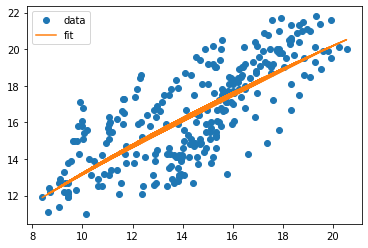

In [254]:
fit_y = MartinezCano(xdata, p1, p2, p3)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [265]:
xdata = average_BA_H_per_year['AverageD (cm)']
ydata = average_BA_H_per_year['Height (m)']
parameters, covariance = curve_fit(MartinezCano, xdata, ydata)

/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [266]:
p1 = parameters[0]
p2 = parameters[1]
p3 = parameters[2]
print (p1,p2,p3)

16.50133333333333 21.694849379428252 138.44983971834642


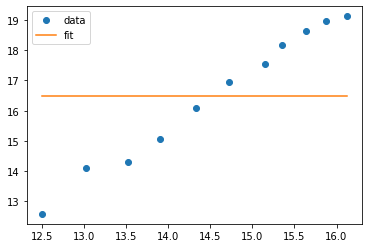

In [267]:
fit_y = MartinezCano(xdata, p1, p2, p3)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

In [268]:
xdata

0     12.502950
1     13.023881
2     13.519659
3     13.908334
4     14.335852
5     14.725759
6     15.152935
7     15.346803
8     15.637153
9     15.878199
10    16.118943
Name: AverageD (cm), dtype: float64

In [260]:
# Using all the data for plot 3 and year 2007
merged_df_2007 = merged_df[merged_df['Year'] == 2007]

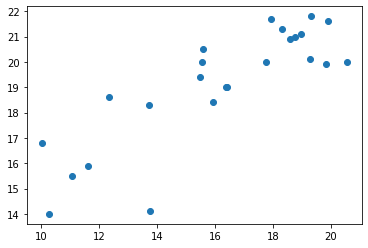

In [261]:

xdata = merged_df_2007['AverageD (cm)']
ydata = merged_df_2007['Height (m)']

plt.scatter(xdata,ydata)

In [262]:
parameters, covariance = curve_fit(MartinezCano, xdata, ydata)
parameters

/Users/ud4/opt/anaconda3/envs/pyces/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([31.35883053,  1.18035964, 16.52391932,  1.        ])

In [263]:
p1 = parameters[0]
p2 = parameters[1]
p3 = parameters[2]

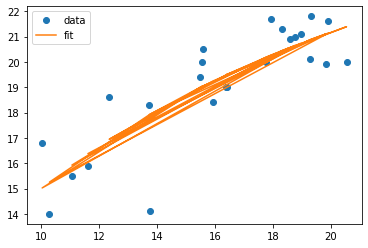

In [264]:
fit_y = MartinezCano(xdata, p1, p2, p3)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

### 2. Power function
h = (p1 * d**(p2))

<br>
where, <br>
h in m <br>
d in cm <br>

In [15]:
# Define the Martinez Cano function
def PowerFunc(d, p1, p2):
    h = p1 * d**(p2)
    return h

[0.20302727 1.64087179]


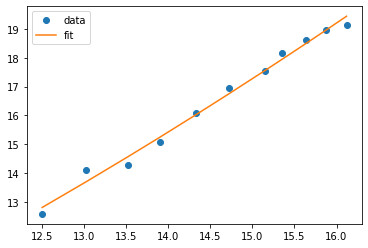

In [197]:
xdata = average_BA_H_per_year['AverageD (cm)']
ydata = average_BA_H_per_year['Height (m)']
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

### 3. Obrien
h = 10**(log10(d)*p1+p2)

<br>
where, <br>
h in m <br>
d in cm <br>

In [10]:

import math

def Obrien(d, p1, p2):
    """
    https://bg.copernicus.org/articles/16/847/2019/
    """
    h = 10 ** (np.log10(d)* p1 + p2)
    return h



[ 1.64087178 -0.69244563]


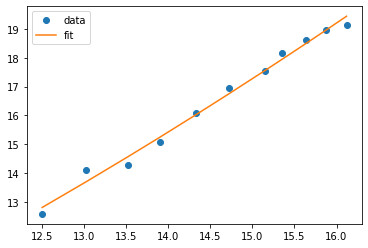

In [209]:
xdata = average_BA_H_per_year['AverageD (cm)']
ydata = average_BA_H_per_year['Height (m)']
parameters, covariance = curve_fit(Obrien, np.array(xdata), np.array(ydata))
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

## Conclusion ORNL Parameter d2h
For our data for Sweetgum we can use: <br>

| Obrien | p1 = 1.6409 | p2= -0.6924 | <br>
| Power | p1 = 0.20302727 | p2 = 1.64087179| <br>

Martinez Cano Fit fails

## Aboveground Biomass Allometry

## Norby 2021:

(DM) = −2.24 + 0.355 * A1.3

In [275]:
def Norby_AGB (d):
    """
    d: cm

    returns
    -------
    bagw in kg
    """
    bagw = -2.24 + 0.355 * np.pi*d**2/4.0
    return bagw


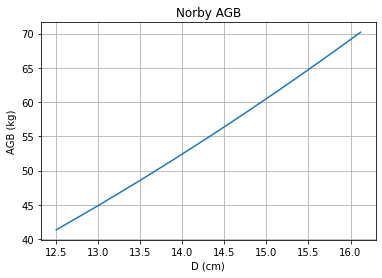

In [276]:
xdata = average_BA_H_per_year['AverageD (cm)']
Norby_agb = Norby_AGB(xdata)
plt.plot(xdata, Norby_agb, '-', label='Norby AGB')
plt.title('Norby AGB')
plt.xlabel('D (cm)')
plt.ylabel('AGB (kg)')
plt.grid(True)

### Two Parameter Power Function
    ! =========================================================================
    ! This function calculates tree above ground biomass according to 2
    ! parameter power functions. (slope and intercepts of a log-log
    ! diameter-agb fit:
    !
    ! These relationships are typical for temperate/boreal plants in North
    ! America.  Parameters are available from Chojnacky 2014 and Jenkins 2003
    !
    ! Note that we are using an effective diameter here, as Chojnacky 2014
    ! and Jenkins use diameter at the base of the plant for "woodland" species
    ! The diameters should be converted prior to this routine if drc.
    !
    ! Input arguments:
    ! diam: effective diameter (d or drc) in cm
    ! FOR SPECIES THAT EXPECT DCM, THIS NEEDS TO BE PRE-CALCULATED!!!!
    ! Output:
    ! agb:   Total above ground biomass [kgC]

In [282]:
def PP2_bagw(d, p1, p2, c2b=2):
    bagw = (p1 * d**p2) / c2b
    return bagw
c2b = 2
# so
def PP2_bagw(d, p1, p2):
    bagw = (p1 * d**p2) / 2
    return bagw


[0.43146431 2.08115839]


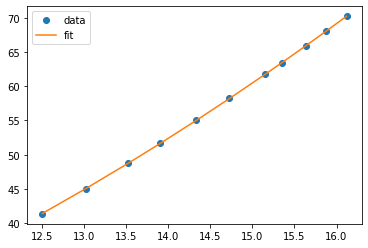

In [283]:
xdata = average_BA_H_per_year['AverageD (cm)']
ydata = Norby_agb
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
plt.plot(xdata, Norby_agb, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

### Chave's

    ! Input arguments:
    ! d: Diameter at breast height [cm]
    ! rho:  wood specific gravity (dry wood mass per green volume)
    ! height: total tree height [m]
    ! a1: structural biomass allometry parameter 1 (intercept)
    ! a2: structural biomass allometry parameter 2 (slope)
    ! Output:
    ! bagw:   Total above ground biomass [kgC]
    !
    ! Chave's Paper has p1 = 0.0673, p2 = 0.976

In [308]:
def Chave_bagw(d, h, wood_density, p1, p2, c2b):
    bagw = (p1 * (wood_density * d**2.0 * h)**p2) / c2b
    return bagw

# For ORNL
# wood_density = .51
# c2b=2




[1.58630521 0.57085158]


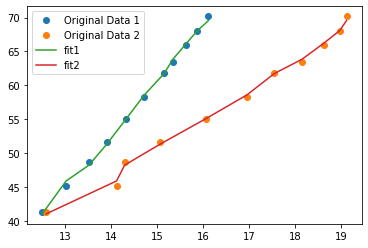

In [312]:
# Combine the x values into a single array
x1 = np.array(average_BA_H_per_year['AverageD (cm)'])
x2 = np.array(average_BA_H_per_year['Height (m)'])
x_combined = np.column_stack((x1, x2))

ydata = Norby_agb

# Re-working the function to make it to work for multiple x inputs
def Chave_bagw(x, p1, p2):
    bagw = (p1 * (0.51 * x[:, 0]**2.0 * x[:, 1])**p2) / 2
    return bagw

# Perform the curve fit
parameters, covariance = curve_fit(Chave_bagw, x_combined, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Chave_bagw(x_combined, p1, p2)
plt.plot(x_combined[:, 0], Norby_agb, 'o', label='Original Data 1')
plt.plot(x_combined[:, 1], Norby_agb, 'o', label='Original Data 2')
plt.plot(x_combined[:, 0], fit_y, '-', label='fit1')
plt.plot(x_combined[:, 1], fit_y, '-', label='fit2')
plt.legend()

## Parameter AGB Sweetgum: 
Using 2 parameter power function: <br>
p1 = 0.43146431 ; p2 = 2.08115839 <br>

Using Chave function: <br>
p1 = 1.58630521 ; p2 = 0.57085158 <br>

# DUKE
35° 58' 41.430"N, 79° 05' 39.087" W, 163 m asl ~ (36,-79)


## Duke height allometry


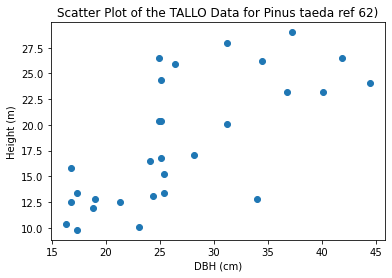

In [14]:
# ref: 62

# Your data
data = [
    (16.3, 10.4),
    (16.8, 12.5),
    (16.8, 15.8),
    (17.3, 13.4),
    (17.3, 9.8),
    (18.8, 11.9),
    (19, 12.8),
    (21.3, 12.5),
    (23.1, 10.1),
    (24.1, 16.5),
    (24.4, 13.1),
    (24.9, 20.4),
    (24.9, 26.5),
    (25.1, 24.4),
    (25.1, 16.8),
    (25.1, 20.4),
    (25.4, 15.2),
    (25.4, 13.4),
    (26.4, 25.9),
    (28.2, 17.1),
    (31.2, 20.1),
    (31.2, 28),
    (34, 12.8),
    (34.5, 26.2),
    (36.8, 23.2),
    (37.3, 29),
    (40.1, 23.2),
    (41.9, 26.5),
    (44.5, 24.1)
]

# Separate the data into x and y values
x_values, y_values = zip(*data)

# Plot the data
plt.scatter(x_values, y_values)
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Scatter Plot of the TALLO Data for Pinus taeda ref 62)')
plt.show()


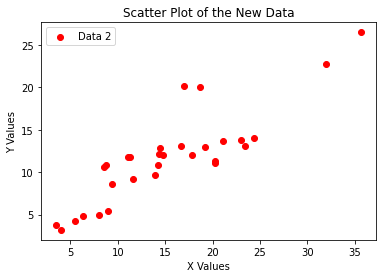

In [17]:
# ref 17

# Your new data
data2 = [
    (3.5, 3.8),
    (4, 3.2),
    (5.5, 4.3),
    (6.3, 4.8),
    (8, 4.9),
    (8.5, 10.6),
    (8.8, 10.8),
    (9, 5.4),
    (9.4, 8.6),
    (11.1, 11.8),
    (11.3, 11.8),
    (11.6, 9.2),
    (13.9, 9.7),
    (14.2, 10.8),
    (14.3, 12.1),
    (14.4, 12.8),
    (14.8, 12),
    (16.7, 13.1),
    (17, 20.2),
    (17.8, 12),
    (18.7, 20.1),
    (19.2, 13),
    (20.2, 11.1),
    (20.2, 11.3),
    (21.1, 13.7),
    (23, 13.8),
    (23.4, 13.1),
    (24.4, 14),
    (32, 22.7),
    (35.6, 26.5)
]

# Separate the data into x and y values
x_values2, y_values2 = zip(*data2)

# Plot the new data
plt.scatter(x_values2, y_values2, color='red', label='Data 2')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of the New Data')
plt.legend()
plt.show()


## Power function : d2h | Duke | ref62

[1.39568721 0.78584162]


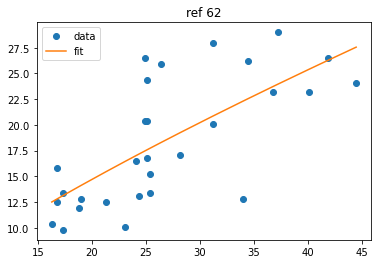

In [18]:
xdata = x_values
ydata = y_values
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.title("ref 62")
plt.legend()

## Power function : d2h | Duke | ref17

[1.43476856 0.77807518]


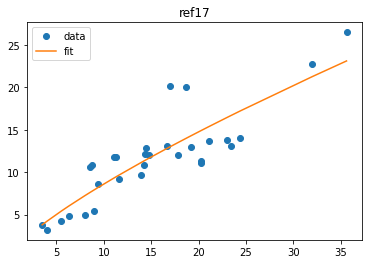

In [19]:
xdata = x_values2
ydata = y_values2
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.title("ref17")
plt.legend()

### Obrien  : d2h | Duke | ref62

[0.78584147 0.14478831]


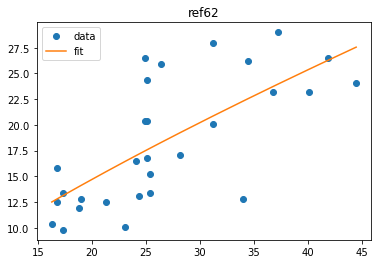

In [21]:
xdata = x_values
ydata = y_values
parameters, covariance = curve_fit(Obrien, np.array(xdata), np.array(ydata))
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.title("ref62")
plt.legend()

### Obrien  : d2h | Duke | ref17

[0.7780761  0.15678067]


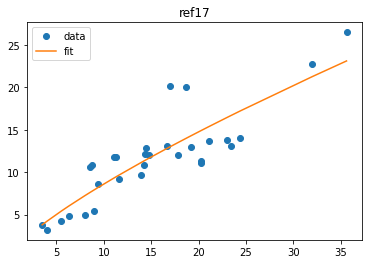

In [22]:
xdata = x_values2
ydata = y_values2
parameters, covariance = curve_fit(Obrien, np.array(xdata), np.array(ydata))
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.title("ref17")
plt.legend()

## Conclusion DUKE d2h 
### ref 62
Power function: [1.39568721 0.78584162] <br>
Obrien : [0.78584147 0.14478831] <br>

### ref 17
Power function: [1.43476856 0.77807518] <br>
Obrien : [0.7780761  0.15678067] <br>

## Duke Allometries from Dohyoung Kim 2019 paper
doi: 10.1111/gcb.14971 <br>

[Figure 1 : H-DBH for harvested trees](/Users/ud4/Documents/FACEMDS/Figures/Kim_2019_Allometry/Kim_Fig1.png)

